In [6]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
// Code to be able to number equations in the markdown

<IPython.core.display.Javascript object>

## Explicit finite difference scheme

### Rewriting equation in terms of row (position) and column (time) indicies.

The equation (Eq. 4.0 in doc) given to me by Jack is: 

$$ E^{n+1}_i = \left ( \frac{\Delta t}{\Delta x} \frac{c}{n} \right )^2 (E^{n}_{i+1} - 2E^{n}_{i} + E^{n}_{i-1})-(-2E^{n}_{i} + E^{n-1}_{i}) $$

I want to have the equation in terms of rows and columns, so ultimately I want to rewrite the following equation to be in the form of rows and columns: 

\begin{equation}
u^{n+1}_{j} = ru^{n}_{j-1} + (1-2r)u^{n}_{j} + ru^{n}_{j+1}
\end{equation}

where $ \displaystyle r = \left ( \frac{\Delta t}{\Delta x} \frac{c}{n} \right ) $ and n is the position index and j is the time index

So I express the above equation as:

\begin{equation}
u^{n}_{j} = ru^{n-1}_{j-1} + (1-2r)u^{n}_{j-1} + ru^{n+1}_{j-1} 
\end{equation}

This is going to calculate a value based on a weighted average. If we think of a matrix, it will use a sum of the previous
time value and it's adjacent values. 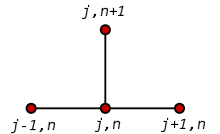

Using the image below, we use j,n;j-1,n;j+1,n and take a weighted average to find j,n+1. However we can define our j,n+1 point to be j,n and then use Eq(2) to find the value.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

#### Function 'ElectricFieldExplicit takes the following inputs:

* **x**, the input vector x to represent spatial coordinates. This will be a vector of equal step size, **h**.

* **t**, the input vector t to represent time coordinates. This will be a vector of equal step size, **k**.

* **boundary_conditions**, the boundary conditions (not sure what to do here yet) E(x=0, t) and E(x=?, t) ??

* **initial_conditions**, the initial conditions



In [15]:
# I believe I need two different time steps. One time step for spatial derivative and one for time derivative.
h = 0.25
k = 0.25

# create a range of numbers from 0 to 1. Not sure what range is best exactly.
# we add the step size to the range so that it includes the last value
x = np.arange(0, 1 + h, h)
t = np.arange(0, 1 + k, k)

In [16]:
# We need to initialize a E matrix which will store our values to go through in it.
n = len(x)
m = len(t)

E = np.zeros((n, m))
E

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])